# House Prices: Advanced Regression Techniques

Skewness: 1.882876
Kurtosis: 6.536282


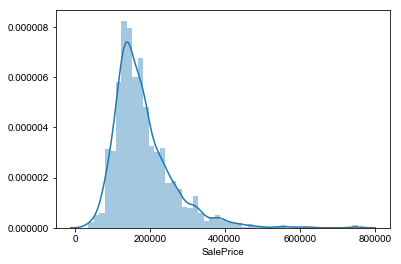

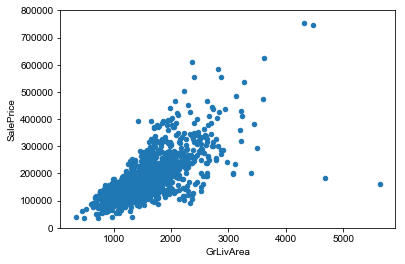

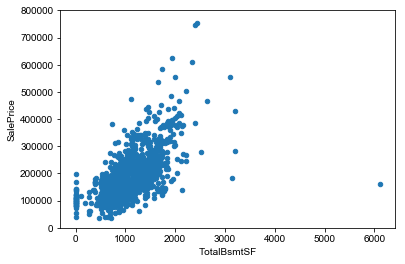

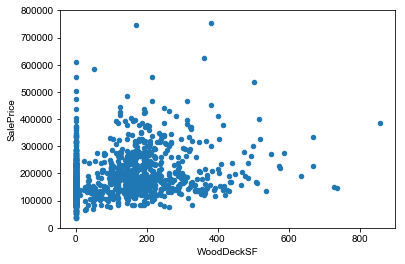

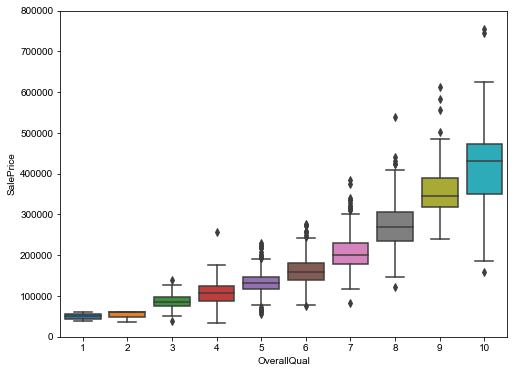

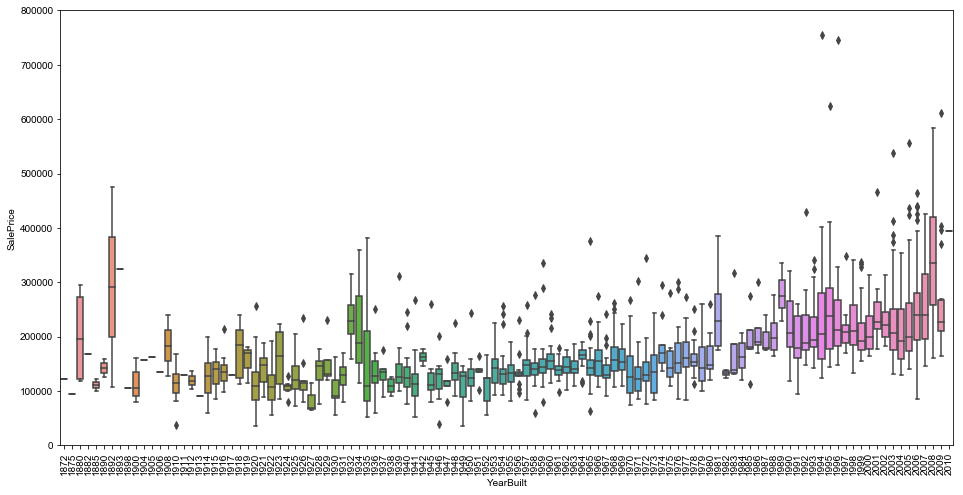

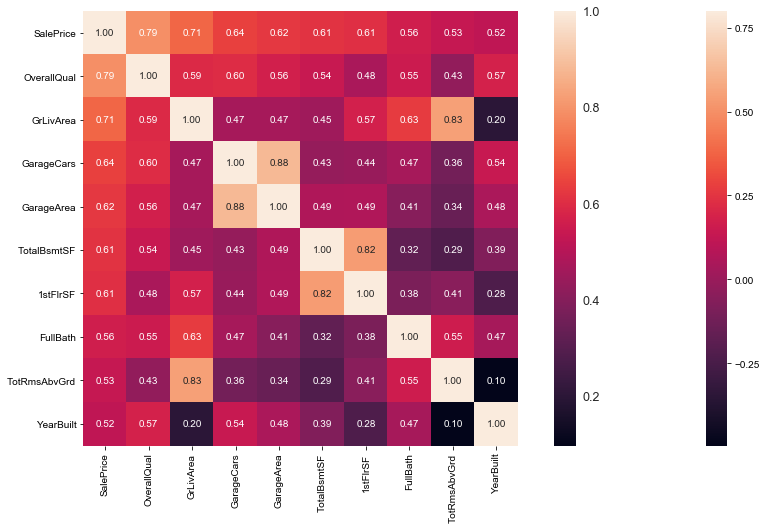

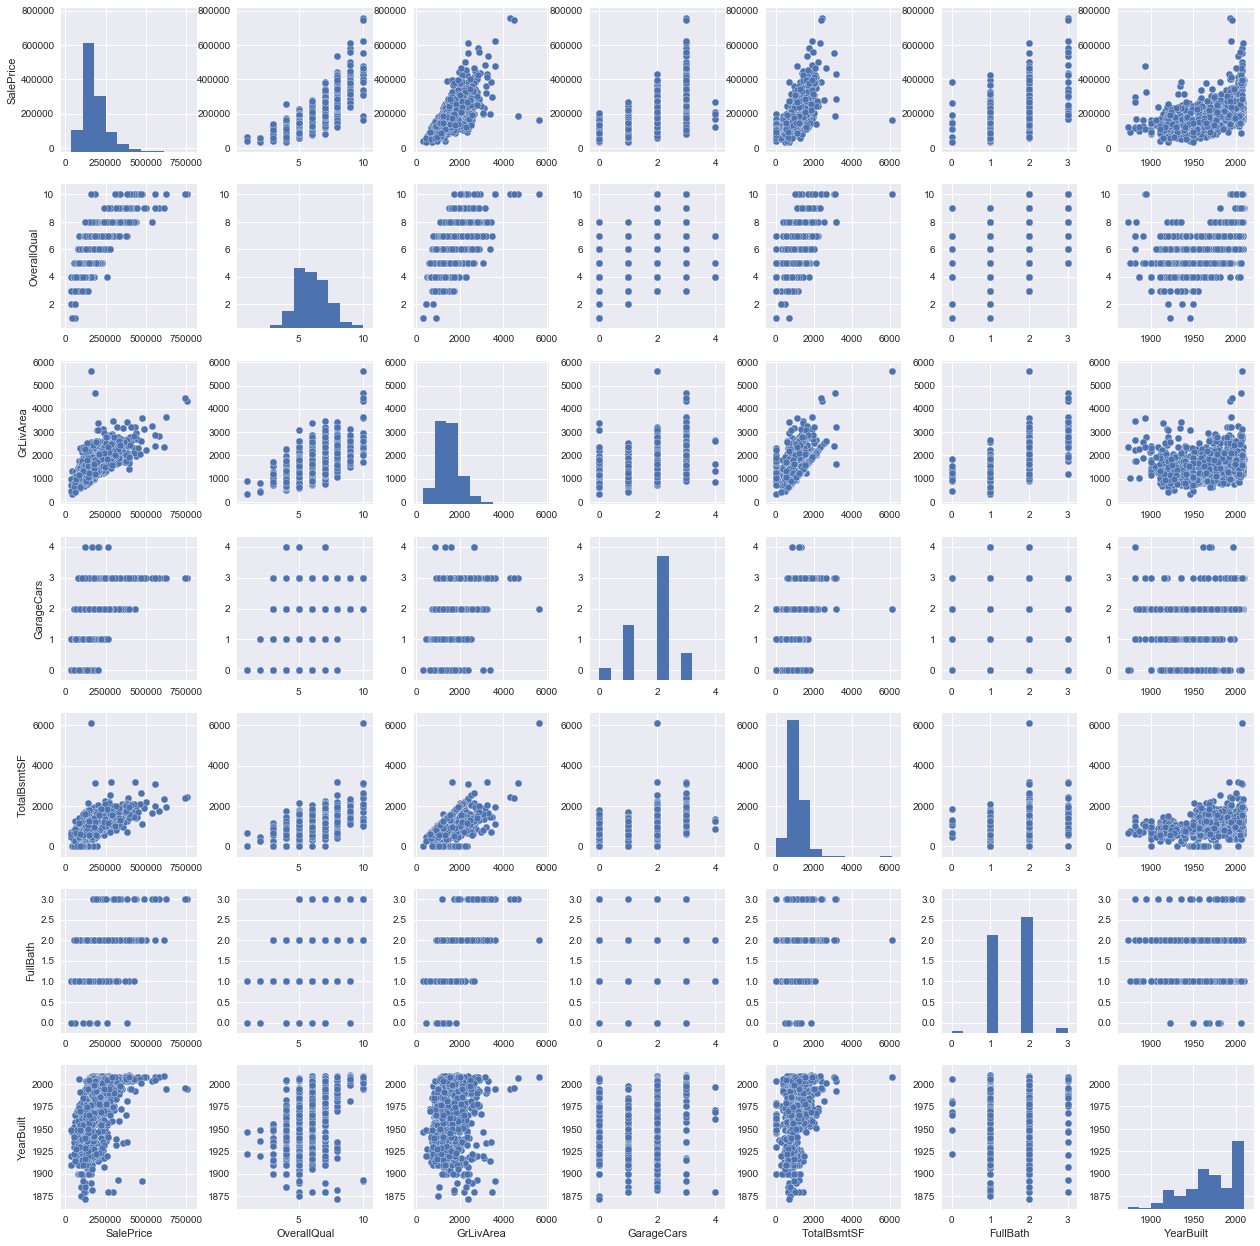

In [1]:
# 疑问？: 缺失值未处理
# import the module 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
# 用于忽略程序运行过程中产生的警告信息
%matplotlib inline
# 此语句只有在jupyter中使用，而且可以确定生成的图像直接在console界面显示

# bring in the six packs
df_train = pd.read_csv('./house_prices_advanced_regression_techniques/train.csv')
df_test = pd.read_csv('./house_prices_advanced_regression_techniques/test.csv')
# check the data constructure
df_train.columns

# 得到数据的总体描述 descriptive statistics summary
df_train['SalePrice'].describe()

# 得到有关数据信息的图像表示
sns.distplot(df_train['SalePrice'])

# 得到关于房子售价的 偏度 和 返回无偏峰度
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

# 关于数值特性中GrLivArea的数值与售价的关系表示
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))

# 接下来是TotalBsmtSF与SalePrice的关系表示
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))

# WooddeckSF
var = 'WoodDeckSF'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))
# WoodDeckSF 产生的数据太丑了

# Relationship with categorical features
# box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
f,ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var,y='SalePrice',data=data)
fig.axis(ymin=0,ymax=800000)
# 通过此图将某一类数据的点分离出来

var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
f,ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var,y='SalePrice',data=data)
fig.axis(ymin=0,ymax=800000)
# xticks将坐标轴上的刻度旋转90度
plt.xticks(rotation=90)

# 查看每一个特征之间的相关性,颜色越淡，相关性越高
# correlation matrix
corrmat = df_train.corr()
f,ax = plt.subplots(figsize=(16,8))
sns.heatmap(corrmat,vmax=.8,square=True)

# 相关性矩阵
# saleprice correlation matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# 找到与SalePrice相关性最大的前10个特征
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)
plt.show()
# according to the result, we should pay more attention to 'YearBuilt'


# according to last result, make the scatter pic with the special features and SalePrice
# scatterplot 
sns.set()
cols = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(df_train[cols],size=2.5)
plt.show()
# 关于对角线上产生的元素 内容是 元素的特征分布图而对角线两侧是点状图



Processing of the missing data

In [2]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

In [3]:
# according some rules the features that have the missing data will be dropped.
# 分别采取了删除 特征和 删除样本
# deal with missing data
df_train = df_train.drop((missing_data[missing_data['Total']>1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() # just checking that there is no missing data missing

df_test = df_test.drop((missing_data[missing_data['Total']>1]).index,1)
df_test = df_test.drop(df_test.loc[df_test['Electrical'].isnull()].index)
df_test.isnull().sum().max() # just checking that there is no missing data missing
 

4

In [4]:
# 将数据转化为  均值为0，标准差为0的数
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
# 这相当于把数据从df_train里面提取出来，然后以列向量的形式输出！！！
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


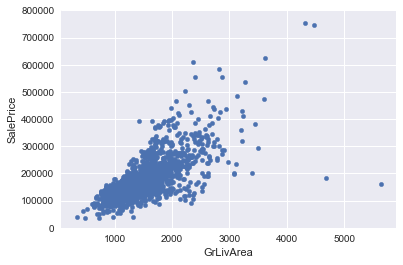

In [5]:
# 从不同的角度观察特征和参数
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))


In [6]:
# delete points that described in last picture  is abnormal 
df_train.sort_values(by = 'GrLivArea',ascending=False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

df_test.sort_values(by = 'GrLivArea',ascending=False)[:2]
df_test = df_test.drop(df_test[df_test['Id'] == 1299].index)
df_test = df_test.drop(df_test[df_test['Id'] == 524].index)

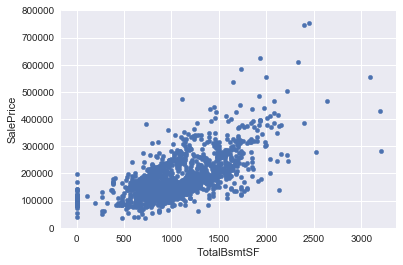

In [7]:
# birvariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))

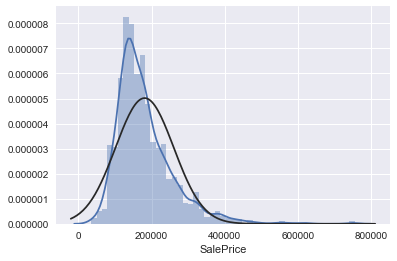

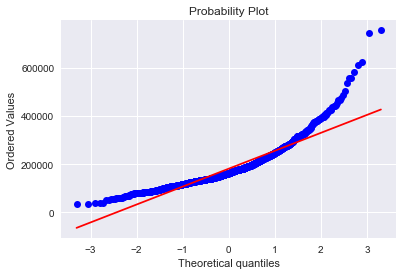

In [8]:
# In the search for normality
# histogram and normal probability plot
sns.distplot(df_train['SalePrice'],fit=norm)
fig = plt.figure()
res  = stats.probplot(df_train['SalePrice'],plot=plt)


In [9]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
# 首先这是使用了log对数据进行了预处理


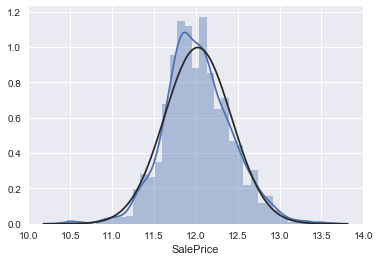

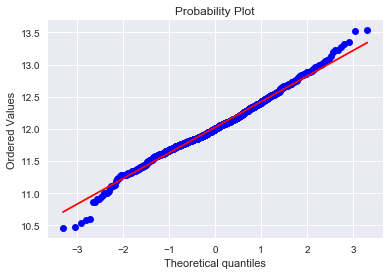

In [10]:
sns.distplot(df_train['SalePrice'],fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'],plot=plt)

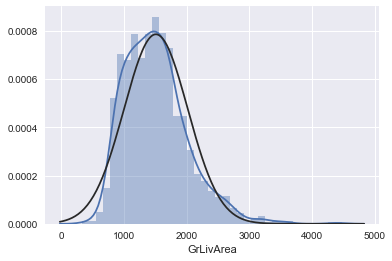

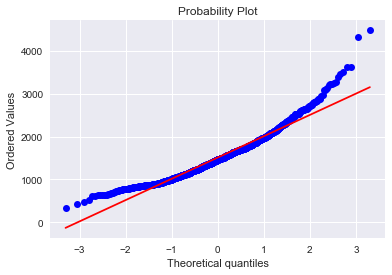

In [11]:
# histogram and normal probability plot
sns.distplot(df_train['GrLivArea'],fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'],plot = plt)
# 在进行回归建模时发现出现了偏差，接下来在使用log 对数据进行预处理

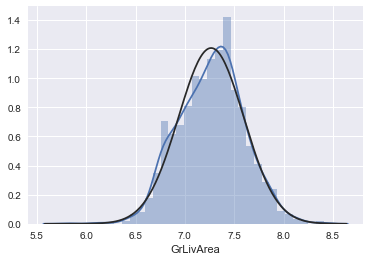

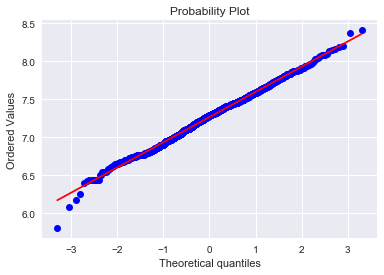

In [12]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

df_test['GrLivArea'] = np.log(df_test['GrLivArea'])
# 此时的底数是e
# 然后使用处理后的数据在进行画图
sns.distplot(df_train['GrLivArea'],fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'],plot=plt)
# 使用处理后的数据进行预处理后得到的数据，在进行线性回归时，数据吻合程度高


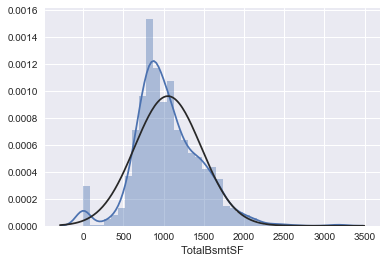

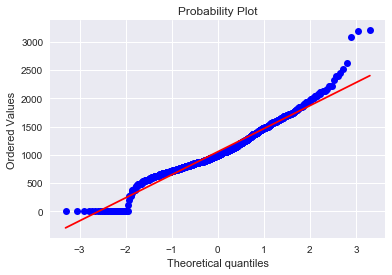

In [13]:
# histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'],fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'],plot=plt)

Ok, now we are dealing with the big boss. What do we have here?
Something that, in general, presents skewness.
A significant number of observations with value zero (houses without basement).
A big problem because the value zero doesn't allow us to do log transformations.
To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

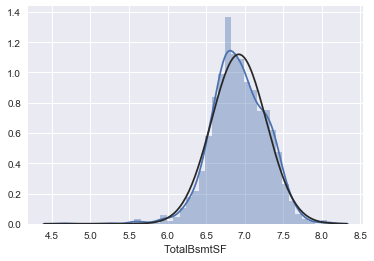

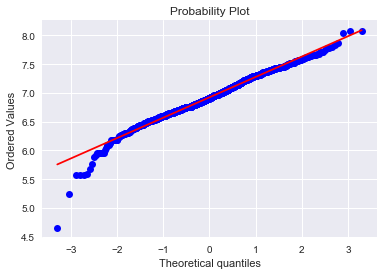

In [14]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area > 0 it gets 1,for area == 0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']),index = df_train.index)
df_train['HasBsmt'] = 0
# 根据第一个参数的判断结果，给新添加列赋值
df_train.loc[df_train['TotalBsmtSF'] > 0,'HasBsmt']  = 1

# transform data
df_train.loc[df_train['HasBsmt'] == 1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
# 如果满足判断条件，才对某个坐标对应的值进行赋值

# histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'],fit=norm)
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'],plot=plt)




df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']),index = df_test.index)
df_test['HasBsmt'] = 0
# 根据第一个参数的判断结果，给新添加列赋值
df_test.loc[df_test['TotalBsmtSF'] > 0,'HasBsmt']  = 1

# transform data
df_test.loc[df_test['HasBsmt'] == 1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
# 如果满足判断条件，才对某个坐标对应的值进行赋值

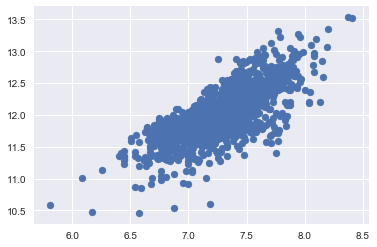

In [15]:
# scatter plot




plt.scatter(df_train['GrLivArea'],df_train['SalePrice'])

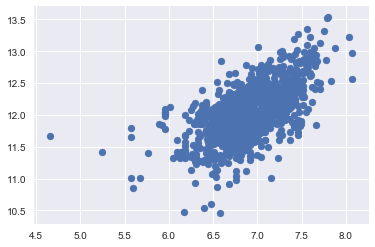

In [16]:
# scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'],df_train[df_train['TotalBsmtSF']>0]['SalePrice'])

In [17]:
# print(pd.get_dummies(df_tra`in))

In [18]:
df_train = pd.get_dummies(df_train)

df_test = pd.get_dummies(df_test)

In [21]:
from sklearn.linear_model import LinearRegression
dds = df_train['SalePrice']
# df_train1 = df_train.drop(['SalePrice',],axis=1)
reg = LinearRegression().fit(df_train[['GrLivArea','OverallQual']],dds)
df_test = pd.read_csv('./house_prices_advanced_regression_techniques/test.csv')
res = reg.predict(df_test[['GrLivArea','OverallQual']])
ddf = pd.DataFrame()
ddf['Id'] = df_test['Id']
ddf['SalePrice'] = res
ddf.to_csv('./submission1.csv',index=False)
# 使用score 需要使用有结果的测试集进行验证，因为没有提前保存要交叉验证的数据，所以无法使用score()函数
# print(df_train.columns)
# print(len(df_test.columns))